<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/A5-Dangerous_streets_NYPD_Collisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Pedestrian Safety in New York City

This notebook explores pedestrian safety in New York City by analyzing collision data to identify areas and streets with a high risk for pedestrians. Our objective is to leverage data analytics and spatial visualization to gain insights into dangerous locations and potentially inform urban planning and safety initiatives.

We will use data from the NYC Open Data portal, specifically the Motor Vehicle Collisions data, and geographical data for New York City.

In [1]:
%pip install  -U -q  google-cloud-bigquery

In [2]:
# This section sets up the Python environment, imports necessary libraries,
# and authenticates access to Google Cloud Platform (GCP) services,
# specifically Google BigQuery.

# Configure the display format for inline plots in the notebook.
# 'retina' provides sharper images on high-resolution screens.
%config InlineBackend.figure_format = 'retina'

# Import essential libraries for data analysis, spatial operations, and visualization.
import geopandas as gpd  # For working with geospatial data (like map boundaries)
import seaborn as sns    # For creating statistical graphics

# Import modules for interacting with Google Cloud services.
from google.cloud import bigquery  # For querying data stored in Google BigQuery
from google.colab import auth      # For authenticating access in Google Colab

# Authenticate the user to access Google Cloud services.
# This will prompt you to log in and authorize access if running in Google Colab.
auth.authenticate_user()

# Set your Google Cloud Project ID.
# *** IMPORTANT: Replace 'ipeirotis-hrd' with your actual GCP project ID. ***
project_id = 'ipeirotis-hrd' # <-- Change this to your project ID!

# Create a BigQuery client object.
# This client is used to send SQL queries to BigQuery and retrieve results.
# We specify the project ID so the client knows which project to use.
bq = bigquery.Client(project=project_id)

## Data Source and Preparation

We are utilizing the NYC Motor Vehicle Collisions dataset, available through Google Cloud's BigQuery public datasets (`nyu-datasets.collisions.collisions`). This dataset contains detailed information about traffic collisions across New York City.

To identify streets with a significantly higher risk for pedestrians, we've formulated a SQL query that calculates the pedestrian fatality rate for each street and compares it to the overall average. We are focusing on streets with a sufficient number of collisions to ensure statistical significance.

The results of this query will be loaded into a Pandas DataFrame for further analysis and visualization.

In [3]:
sql = '''
-- This query identifies the locations of pedestrian injuries or fatalities
-- on streets with a significantly higher pedestrian fatality rate.

WITH
  -- Calculate statistics for each street including total fatalities and total collisions
  StreetStats AS (
    SELECT
      ON_STREET_NAME,
      BOROUGH,
      SUM(PEDESTRIANS_INJURED) + SUM(PEDESTRIANS_KILLED) AS total_fatalities,
      COUNT(*) AS total_collisions
    FROM
      nyu-datasets.collisions.collisions
    WHERE
      ON_STREET_NAME IS NOT NULL -- Exclude collisions without a street name
    GROUP BY
      ON_STREET_NAME,
      BOROUGH
    HAVING
      COUNT(*) >= 50 -- Only consider streets with at least 50 collisions
  ),

  -- Calculate the overall average pedestrian fatality rate across all considered streets
  OverallFatalityRate AS (
    SELECT
      SUM(total_fatalities) / SUM(total_collisions) AS avg_fatality_rate
    FROM
      StreetStats
  ),

  -- Identify streets that have a fatality rate more than 3 times the overall average
  DangerousStreets AS (
    SELECT
      ss.ON_STREET_NAME,
      ss.BOROUGH
    FROM
      StreetStats ss
    CROSS JOIN
      OverallFatalityRate ofr
    WHERE
      ss.total_fatalities / ss.total_collisions > 3 * ofr.avg_fatality_rate
  )

-- Select the latitude and longitude of collisions that occurred on dangerous streets
-- where pedestrians were injured or killed
SELECT
  c.UNIQUE_KEY,
  c.DATE_TIME,
  c.ON_STREET_NAME,
  c.BOROUGH,
  c.LATITUDE,
  c.LONGITUDE
FROM
  nyu-datasets.collisions.collisions c
INNER JOIN
  DangerousStreets ds
ON
  c.ON_STREET_NAME = ds.ON_STREET_NAME
  AND c.BOROUGH = ds.BOROUGH
WHERE
  c.PEDESTRIANS_INJURED > 0 -- Include collisions with injured pedestrians
  OR c.PEDESTRIANS_KILLED > 0 -- Include collisions with killed pedestrians
'''

df = bq.query(sql).to_dataframe()


In [4]:
display(df)

,UNIQUE_KEY,DATE_TIME,ON_STREET_NAME,BOROUGH,LATITUDE,LONGITUDE
0,4412761,2021-05-02 23:14:00+00:00,FOREST AVENUE,Staten Island,40.628940,-74.116196
1,4415718,2021-05-11 17:05:00+00:00,AUDUBON AVENUE,Manhattan,40.851110,-73.930610
2,4418956,2021-05-22 00:40:00+00:00,JAMAICA AVENUE,Queens,40.715763,-73.746540
3,4421791,2021-05-30 09:47:00+00:00,FOREST AVENUE,Staten Island,40.624294,-74.137240
4,4422004,2021-05-30 20:28:00+00:00,WEST 145 STREET,Manhattan,40.822834,-73.941925
...,...,...,...,...,...,...
2255,4779496,2024-12-17 11:51:00+00:00,RICHMOND AVE,Staten Island,40.544430,-74.165400
2256,4780193,2024-12-18 19:40:00+00:00,RICHMOND AVE,Staten Island,40.560250,-74.169740
2257,4780194,2024-12-18 21:40:00+00:00,RICHMOND AVE,Staten Island,40.561092,-74.169830
2258,4783774,2024-12-18 23:23:00+00:00,RICHMOND AVE,Staten Island,40.534267,-74.153980


## Visualizing High-Risk Areas

To understand the spatial distribution of pedestrian injuries and fatalities on these identified dangerous streets, we will visualize the data on a map of New York City.

We will use the `geopandas` library to load the geographical shapefile of NYC boroughs and `seaborn` to create a scatter plot of the collision locations and a Kernel Density Estimate (KDE) plot to highlight areas of high collision density. This visualization will help us visually identify hotspots where pedestrian safety is a significant concern.

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

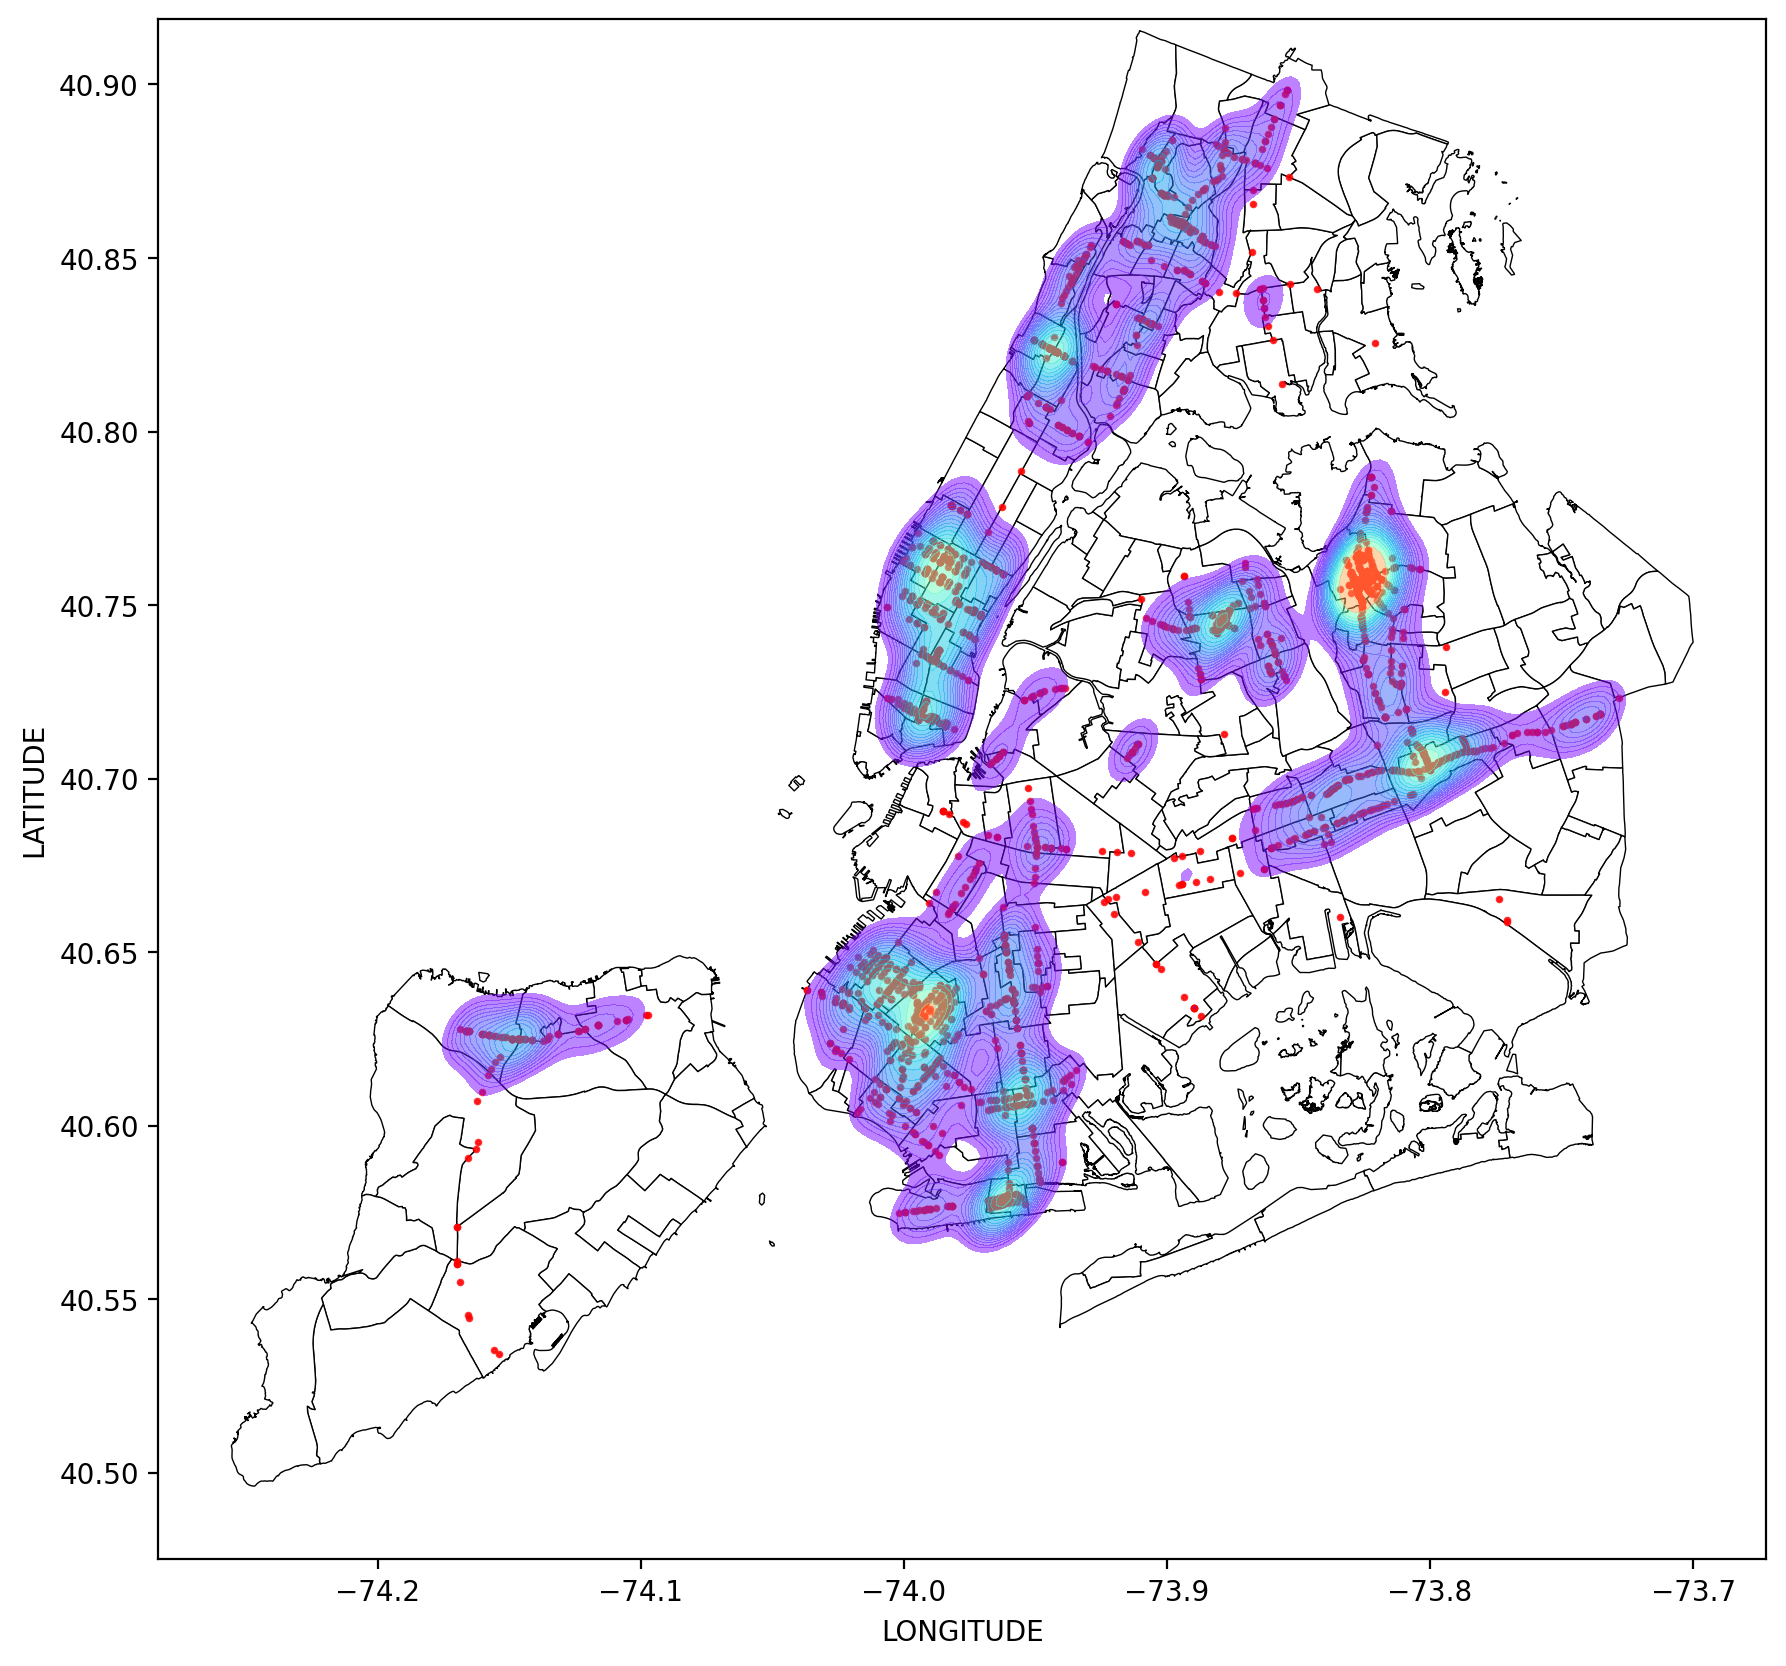

In [5]:
# Define the URL for the GeoJSON file containing NYC borough boundaries
shapefile_url = 'https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson'

# Load the geographical data for NYC boroughs using geopandas
# geopandas reads the GeoJSON file and creates a GeoDataFrame
df_nyc = gpd.GeoDataFrame.from_file(shapefile_url)

# Create the initial plot which is the map of NYC boroughs
# We set the size of the plot and style the borough boundaries
map_plot = df_nyc.plot(
              linewidth=0.5, # makes the lines outlining the boroughs thin
              color='White', # fills the inside of the boroughs with white.
              edgecolor='Black', # makes the outlines of the boroughs black.
              figsize=(15, 10) # sets the overall size of the plot on your screen.
              )

# Overlay a scatter plot on the map to show the location of each accident
# Each point represents an accident with pedestrian injuries or fatalities on a dangerous street
df.plot(
    x='LONGITUDE',      # Use the LONGITUDE column for the x-axis (east-west position)
    y='LATITUDE',       # Use the LATITUDE column for the y-axis (north-south position)
    kind='scatter',     # Specify that this is a scatter plot (individual points)
    s=3,                # Set the size of each scatter point
    c='red',            # Set the color of the scatter points to red
    ax = map_plot,      # Crucially, plot on the same axes as the NYC map (overlaying)
    alpha = 0.8         # Make the points slightly transparent for better visibility where points overlap
)

# Add a Kernel Density Estimate (KDE) plot to visualize areas with high concentrations of accidents
# This helps to visually identify accident hotspots
sns.kdeplot(
    data=df,         # Use the same accident data
    x='LONGITUDE',   # Use longitude for the x-axis
    y='LATITUDE',    # Use latitude for the y-axis
    fill=True,       # Fill the density areas with color
    thresh=0.10,     # Only show areas with density above a certain threshold (reduces clutter)
    levels=20,       # Draw 20 contour levels to show gradations in density
    cmap='rainbow',  # Use the 'rainbow' color map for the density areas
    ax=map_plot,     # Draw this KDE plot on the same axes as the map and scatter plot
    alpha = 0.5,     # Make the density areas semi-transparent
    bw_adjust=0.3    # Adjusts the smoothness of the density contours
                     # (smaller values make it more jagged, larger values smoother)
)

## Discussion and Potential Insights

The map visualization will help us answer questions such as:

*   Which boroughs or specific areas have the highest concentration of pedestrian injuries and fatalities on high-risk streets?
*   Are there specific patterns or clusters of collisions that suggest common underlying causes?

The insights gained from this analysis can be valuable for:

*   **Urban Planners:** Identifying areas that require traffic calming measures, improved pedestrian infrastructure, or targeted safety campaigns.
*   **Policy Makers:** Informing the development of new safety regulations and enforcement strategies.
*   **Transportation Authorities:** Prioritizing resources for safety improvements in high-risk locations.

This analysis serves as an example of how publicly available data and analytical tools can be used to address real-world urban challenges and inform data-driven decision-making.